# Engine Insights

## Overview 
 
Howso Engine is a generalized Machine Learning (ML) and Artificial Intelligence platform that creates powerful decision-making models that are fully explainable, auditable, and editable. Howso Engine uses Instance-Based Machine Learning which stores instances, i.e., data points, in memory and makes predictions about new instances given their relationship to existing instances. This technology harnesses a fast spatial query system and techniques from information theory to enhance both performance and accuracy. 

In this notebook we will explore the most basic workflow using Howso Engine to gain insights in your data. This workflow is a form of exploratory data analysis and can help the user develop a deeper understanding of the data.

In [1]:
import os

import numpy as np
import pandas as pd
import plotly.io as pio
import plotly.express as px
from pmlb import fetch_data

from howso.engine import Trainee
from howso.utilities import infer_feature_attributes

pio.renderers.default = os.getenv("HOWSO_RECIPE_RENDERER", "notebook")

# Section 1: Load, Train, Analyze

The [basic workflow guide](https://docs.howso.com/user_guide/basics/basic_workflow.html) goes into more specifics about the individual details of this section. This recipe will focus more on the insights.

### Step 1: Load Data and Create Trainee

In [2]:
df = fetch_data('iris', local_cache_dir="../../data/iris")

# Randomly insert nulls for insights later in recipe
num_nans = int(0.05 * len(df))
nan_indices = np.random.choice(df.index, num_nans, replace=False)
df.loc[nan_indices, 'sepal-width'] = np.nan

# Infer feature attributes
features = infer_feature_attributes(df)

# Create the Trainee
t = Trainee(features=features)

### Step 2: Train, Analyze, and React

In [3]:
# Train
t.train(df)

# Targetless Analysis
t.analyze()

# Section 2: Insights

By calling `get_prediction_stats`, Howso Engine calculates a variety of metrics that are easily accessible and doesn't require further recalculations.

### Insight 1: Marginal Stats

Howso provides easily accessible feature-level descriptive statistics of your dataset. The type of descriptive statistics that are available is dependent on whether the data is continuous or nominal.

In [4]:
marginal_stats = t.get_marginal_stats()
marginal_stats

,sepal-width,sepal-length,petal-width,target,petal-length
stddev,0.431111,0.825301,0.760613,NaN,1.758529
mode,3.000000,5.000000,0.200000,2.000000,1.500000
percentile_75,3.300000,6.400000,1.800000,NaN,5.100000
max,4.400000,7.900000,2.500000,NaN,6.900000
uniques,23.000000,35.000000,22.000000,3.000000,43.000000
entropy,NaN,NaN,NaN,1.098612,NaN
mean,3.050350,5.843333,1.198667,NaN,3.758667
percentile_25,2.800000,5.100000,0.300000,NaN,1.600000
skew,0.342931,0.311753,-0.103944,NaN,-0.271712
variance,0.185857,0.681122,0.578532,NaN,3.092425


### Insight 2 : Which features are my data good at predicting?

Howso provides insights into whether a feature is predictable within a data analysis workflow. This can be analyzed depending on a feature's type, e.g., continuous vs. nomimal. 

For continuous features, Howso provides the feature's mean value and units and calculates its residual. The residuals are quantified by the `mean absolute error (MAE)` between a predicted value and actual value for a prediction and they describe the average amount a feature's predicted value varies from its real value. A feature with a small `MAE` is generally easier to predict than a feature with a large `MAE`. With this information, an subject matter expert will be able to determine the predictability of a feature, given the information contained in the remaining data. For additional context, Howso provides the `R^2`, `RMSE`, and `Spearman coefficient` for each feature. To compare between the continuous features, Howso orders the resulting features by highest `R^2` and `Spearman coefficient` values which are unitless and thus comparable between continuous features. This order represents a probable rank order of feature predictability. However, it is important that further analysis is performed to better understand these results, as they are dataset dependent.

For nominal features, Howso provides information on the feature's accuracy, precision, and recall as well as the Matthews Correlation Coefficient. This provides a holistic view as to whether the feature can be predicted given the remaining information. 

**Note**: Engine insights provide a baseline set of information based on an analysis across all features that points users in the correct direction of feature predictability. If an analysis is performed with a specified target feature, this analysis will become more precise, but the directionality will generally not change.

In [5]:
pred_stats = t.get_prediction_stats(details = {'prediction_stats': True})

pred_stats

,sepal-width,target,sepal-length,petal-width,petal-length
missing_value_accuracy,0.000000,NaN,NaN,NaN,NaN
precision,NaN,0.960000,NaN,NaN,NaN
accuracy,NaN,0.960000,NaN,NaN,NaN
spearman_coeff,0.685641,NaN,0.878441,0.878165,0.892241
adjusted_smape,7.470593,NaN,4.526525,15.405727,6.376508
mcc,NaN,0.940000,NaN,NaN,NaN
recall,NaN,0.960000,NaN,NaN,NaN
mae,0.230083,0.049606,0.266439,0.128103,0.207856
smape,7.595871,NaN,4.565994,17.613472,6.517385
rmse,0.306496,NaN,0.338381,0.170872,0.266026


#### Metrics for continuous features

In [6]:
u_eps = marginal_stats.loc[['mean','stddev'], marginal_stats.columns != 'target']
cts_stats = pred_stats.loc[['r2','spearman_coeff','mae','rmse'], marginal_stats.columns != 'target']
cts_results = pd.concat([u_eps,cts_stats]).transpose().sort_values(by='r2',ascending=False)
cts_results

,mean,stddev,r2,spearman_coeff,mae,rmse
petal-length,3.758667,1.758529,0.977115,0.892241,0.207856,0.266026
sepal-length,5.843333,0.825301,0.831892,0.878441,0.266439,0.338381
sepal-width,3.050350,0.431111,0.494558,0.685641,0.230083,0.306496
petal-width,1.198667,0.760613,NaN,NaN,NaN,NaN
target,NaN,NaN,NaN,NaN,0.049606,NaN


#### Metrics for nominal features

In [7]:
target_stats = pred_stats[['target']]
target_stats.loc[['accuracy','precision','recall']]

,target
accuracy,0.96
precision,0.96
recall,0.96


### Insight 3: Which features are important?

Feature importance is quantified by a combined analysis of how much each feature contributes to the prediction of another feature and whether that contribution improves or harms the accuracy of the prediction. For a given target (i.e., action, predicted) feature, Howso can calculate the [Feature Contribution](https://docs.howso.com/getting_started/terminology.html#contribution), which 
is the difference between a prediction of a target feature when each context feature is considered versus not considered during the prediction.

Howso can also calculate the [Mean Decrease in Accuracy](https://docs.howso.com/getting_started/terminology.html#mda) (MDA). Please see the [feature importance user guide](https://docs.howso.com/user_guide/advanced_capabilities/feature_importance.html) page for more details.

Howso summarizes the feature contribution results for each feature within matrices. To read a matrix, the label of each row (listed on the y-axis) indicates the target feature. Moving from left to right across each row of a matrix, the feature contribution of each context feature for the target feature prediction can be identified. 

Note, the matrices also provide some insight into directional causality between features. This insight is useful for data scientists performing an exploratory data analysis (EDA).

In [8]:
contrib_matrix = t.get_contribution_matrix()

   sepal-length  petal-width    target  petal-length
0      0.133978     0.121012  0.073535      0.113252


   sepal-width  petal-width    target  petal-length
0     0.193024     0.184039  0.158025      0.277023


   sepal-width  sepal-length    target  petal-length
0     0.089769      0.167912  0.216212      0.204037


   sepal-width  sepal-length  petal-width  petal-length
0     0.063547      0.111776     0.241564      0.224568


   sepal-width  sepal-length  petal-width    target
0     0.187086      0.395727      0.40729  0.392693


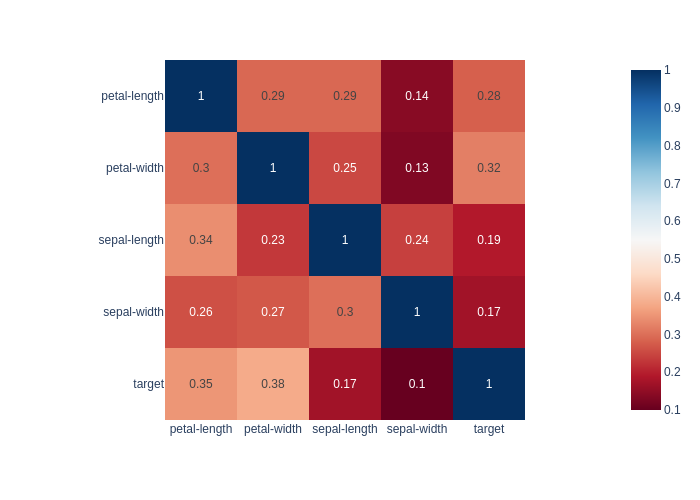

In [9]:
# Plot the heatmap
fig = px.imshow(round(contrib_matrix, 2), color_continuous_scale='RdBu', text_auto=True)
fig.show()

### Insight 4: Which cases are anomalous?

Howso provides insights into the anomalies within your dataset, utilizing the concept of [Conviction](https://docs.howso.com/getting_started/terminology.html#conviction) or how surprising a single data point is relative to the remaining data. The higher the surprisal (lower the conviction), the more likely the data point is anomalous. An outlier is classified as an anomalous point that is very far away from any other data.

Howso also has the ability to classify inliers, which are anomalous points that are very near (e.g., essentially overlapping) with another data point. More information is provided in the `Anomaly_detection.ipynb` recipe.

As assessment of anomalous data points are an important tool for data preparation and results explanation within a data analytics workflow.

In [10]:
t.react_into_features(
    distance_contribution=True,
    familiarity_conviction_addition=True,
    familiarity_conviction_removal=True,
    influence_weight_entropy=True,
    p_value_of_addition=True,
    p_value_of_removal=True,
    similarity_conviction=True
)


conviction = t.get_cases(
    session=t.active_session,
    features=df.columns.to_list() + ['distance_contribution', 'similarity_conviction']
)

# Threshold to determine which cases will be deemed anomalous
conviction_threshold = 1.0

# Extract the anomalous cases
low_conviction = conviction[
    conviction['similarity_conviction'] <= conviction_threshold
].sort_values('similarity_conviction', ascending=True)

# Average distance contribution will be used to determine if a case is an outlier or inlier
average_dist_contribution = low_conviction['distance_contribution'].mean()

# A case with distance contribution greater than average will be tagged as outlier, and vice versa for inliers
category = [
    'outlier' if d > average_dist_contribution else
    np.nan for d in low_conviction['distance_contribution']
]
low_conviction['category'] = category

The anomalous cases, in order of lowest to highest conviction

In [11]:
low_conviction[low_conviction['category']=='outlier']

,sepal-length,sepal-width,petal-length,petal-width,target,distance_contribution,similarity_conviction,category
148,5.0,NaN,1.4,0.2,0,23.473033,0.024911,outlier
28,5.7,NaN,1.7,0.3,0,23.360182,0.067998,outlier
82,5.8,NaN,4.1,1.0,1,23.280155,0.074217,outlier
7,5.5,NaN,4.0,1.3,1,23.278462,0.075010,outlier
105,6.4,NaN,5.3,2.3,2,23.329513,0.076882,outlier
75,5.6,NaN,4.9,2.0,2,23.319552,0.082212,outlier
46,6.7,NaN,5.7,2.5,2,23.468130,0.084246,outlier


In [12]:
display(f"There are {len(low_conviction[low_conviction['category']=='outlier'])} potential outliers in the dataset.")

'There are 7 potential outliers in the dataset.'